# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [163]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [164]:
from sklearn.datasets import load_boston

In [165]:
boston = load_boston()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets incl

In [166]:
X = boston["data"]
y = boston["target"]

In [173]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.932175246772296

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [401]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    ds = pd.DataFrame({'real_vals': y})
    ds['preds'] = ds.apply(lambda r: tuple(), axis=1).apply(np.array) # создаю датасет, где строки - значения у, 
    #колонка preds будет хранить массив из предсказаний

    for i in range(num_runs):
        idx = list(np.random.randint(low = 0, high = X.shape[0], size = X.shape[0]))
        not_idx = list(set(list(range(0,y.shape[0],1))) - set(idx))
        
        Xj = X[idx] 
        yj = y[idx]
        Tj = X[not_idx]

        aj = regressor.fit(Xj, yj)
        predsj = regressor.predict(Tj)
            

        ds.loc[not_idx, 'preds'] = list(map(lambda x,y: np.append(x,y), \
            np.array(ds.loc[not_idx, 'preds']), predsj))
    
    ds = ds[ds['preds'].apply(lambda x: len(x)) != 0] # убираю те, что ни разу не попали в out of bag
    ds['errors'] = (ds['real_vals'] - ds['preds'])**2 # квадрат ошибок 
    ds['errors'] = ds['errors'].apply(lambda x: np.mean(x)) # Среднее ошибок
    ds['bias'] = (ds['preds'].apply(lambda x: np.mean(x)) -ds['real_vals'])**2 # смещение
    ds['variance'] = ds['preds'].apply(lambda x: np.var(x)) #дисперсия прогноза

    return np.mean(ds['bias']), np.mean(ds['variance']), np.mean(ds['errors'])
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [314]:
import warnings
warnings.simplefilter('ignore')

In [328]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

mdl1 = LinearRegression()
blr, vlr, elr =compute_biase_variance(mdl1, X, y, num_runs=1000)

mdl2 = DecisionTreeRegressor()
btr, vtr, etr =compute_biase_variance(mdl2, X, y, num_runs=1000)

mdl3 = RandomForestRegressor()
brf, vrf, erf =compute_biase_variance(mdl3, X, y, num_runs=1000)

In [329]:
print(blr, vlr, elr )
print(btr, vtr, etr)
print(brf, vrf, erf)

23.739461738783078 0.9193132544062705 24.65877499318935
10.166814957050605 13.141837638132822 23.30865259518343
10.657511930231724 2.2394158519717378 12.896927782203463


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Блин, так рада! Вообще согласуются) 

У линрега большое смещение, тк линейная модель плохо приближает наши данные, которые, очев, не по линейному закону распределены. Смещение при этом у нее низкое: линии рисуются близко друг к другу, регуляризации нет, так что наклон не слишком меняется.

У дерева большой разброс, тк деревья чувствительны к данным, которые получают на вход и каждый алгоритм оч не похож на другой. При этом и смещение тут норм такое - надо глубину настраивать и другие гиперпараметры

Случайный лес уменьшил разброс от классического дерева, при этом смещение практически не изменилось. На паре показывали, что это особенность bagging - при низкой корреляции алгоритмов разброс снижается с ростом количества деревьев. При этом смещение действительно осталось неизменным.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.



In [331]:
from sklearn.ensemble import BaggingRegressor

mdl4 = BaggingRegressor(mdl1)
bblr, vblr, eblr =compute_biase_variance(mdl4, X, y, num_runs=1000)


mdl5 = BaggingRegressor(mdl2)
bbtr, vbtr, ebtr =compute_biase_variance(mdl5, X, y, num_runs=1000)

mdl6 = BaggingRegressor(mdl3)
bbrf, vbrf, ebrf =compute_biase_variance(mdl6, X, y, num_runs=1000)

In [332]:
print(bblr, vblr, eblr )
print(bbtr, vbtr, ebtr)
print(bbrf, vbrf, ebrf)

23.722327915943342 1.0379281972215868 24.760256113164928
10.671317072583557 3.4605933106723246 14.13191038325588
11.738893762631468 1.3683451661688344 13.107238928800303


__Your answer here:__ Бэггинг должен снижать разброс, а смещение +- таким же оставлять (при нескоррелированных моделях). 

Отметим, что для линрега почти ничего не изменилось. Более того, разброс немного вырос. Это объясняется тем, что модели оказались достаточно скоррелированными друг с другом. 

Для деревьев результат стал похож на результат Рандомного леса из прошлого задания: разброс стал меньше, чем был, смещение немного выросло. Но в сравнении с рандомным лесом, разброс все-таки больще, опять таки, из-за скоррелированности моделей.

Рандомный лес уменьшил разброс и увеличил смещение. Это ожидаемый эффект от бэггинга.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [333]:
from sklearn.model_selection import train_test_split

In [391]:
def plot_predictions(regressor, X, y, ax, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(\
        X, y, test_size=num_test_objects, random_state=42)
    
    x = list(range(1, num_test_objects+1, 1))

    plt.ion()
    plot1 = ax.scatter(x, y_test, c= 'black')

    

    for j in range(num_runs):
        idx = list(np.random.randint(low = 0, high = X.shape[0], size = X.shape[0]))
        
        Xj = X[idx] 
        yj = y[idx]

        aj = regressor.fit(Xj, yj)
        predsj = regressor.predict(X_test)

        plot1 = ax.scatter(x, predsj, c= 'red')
        
    ax.set_title(title)
    plot1 = ax.scatter(x, y_test, c= 'black')
    ax.set(xticks=np.arange(0, num_test_objects+2)) #поставила на 1 больше просто, чтоб было виднее

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

Text(0, 0.5, 'Predictions and Facts')

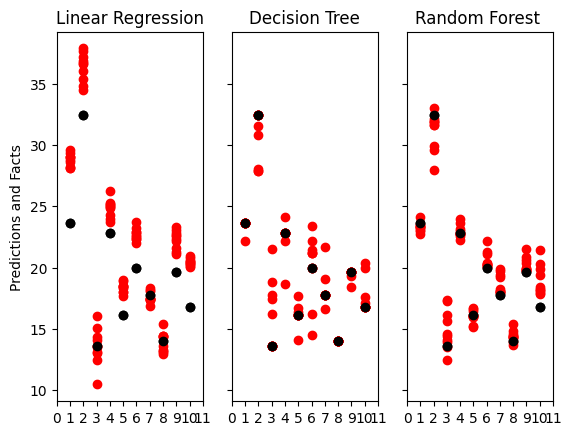

In [395]:
fig, ax = plt.subplots(1, 3, sharey = True)

plot_predictions(mdl1, X, y, num_runs=10, title = 'Linear Regression', ax = ax[0])

plt.subplot(1, 3, 2)
plot_predictions(mdl2, X, y, num_runs=10, title = 'Decision Tree', ax=ax[1])

plt.subplot(1, 3, 3)
plot_predictions(mdl3, X, y, num_runs=10, title = 'Random Forest ', ax=ax[2])

ax[0].set_ylabel('Predictions and Facts')

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ ну тут прям заметно, что у регрессии все предсказания довольно близко между собой, но часто сильно мимо. Поэтому высокое смещение и низкая дисперсия


У дерева наоборот, довольно часто в точку (прям один в один бывало, я первый раз нарисовала черные сначала и их часто не было видно за красными), а вот предсказания нередко далеко друг от друга - высокий разброс, низкое смещение

Рандомный лес выглядит сильно более "скученней", чем просто дерево - предсказания близки друг к другу, почти как у линрега и точность высокая - тоже не было видно черненьких сначала

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [405]:
param_list = []
b_list, v_list = [], []
for depth in range(1, 11):
    param_list.append(depth)
    model=DecisionTreeRegressor(max_depth=depth)
    b, v, _= compute_biase_variance(model, X, y)
    
    b_list.append(b)
    v_list.append(v)


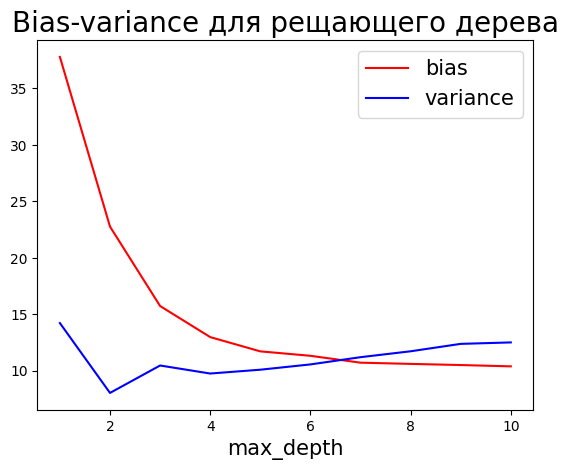

In [406]:
plt.title(f'Bias-variance для глубины рещающего дерева', fontsize=18)
plt.plot(param_list, b_list, color='red', label='bias')

plt.plot(param_list, v_list, color='blue', label='variance')

plt.xlabel('max_depth', fontsize=15)
plt.legend(fontsize=15)

In [409]:
param_list = []
b_list, v_list = [], []
for feat in range(1, X.shape[1]):
    param_list.append(feat)
    model=DecisionTreeRegressor(max_features = feat)
    b, v, _= compute_biase_variance(model, X, y)
    
    b_list.append(b)
    v_list.append(v)

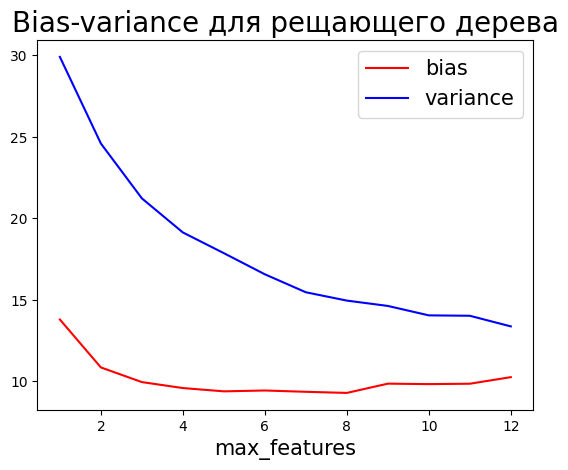

In [410]:
plt.title(f'Bias-variance для количества фичей рещающего дерева', fontsize=18)
plt.plot(param_list, b_list, color='red', label='bias')

plt.plot(param_list, v_list, color='blue', label='variance')

plt.xlabel('max_features', fontsize=15)
plt.legend(fontsize=15)

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [423]:
import tqdm
from tqdm import tqdm

In [424]:
param_list = []
b_list, v_list = [], []
for nest in tqdm(2**np.arange(1, 10)):

    param_list.append(nest)

    model=RandomForestRegressor(n_estimators = nest)
    b, v, _= compute_biase_variance(model, X, y)
    
    b_list.append(b)
    v_list.append(v)

100%|██████████| 9/9 [32:43<00:00, 218.20s/it]


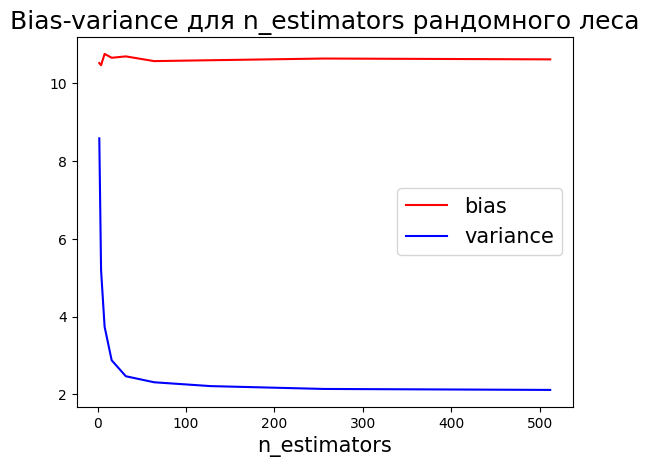

In [425]:
plt.title(f'Bias-variance для n_estimators рандомного леса', fontsize=18)
plt.plot(param_list, b_list, color='red', label='bias')

plt.plot(param_list, v_list, color='blue', label='variance')

plt.xlabel('n_estimators', fontsize=15)
plt.legend(fontsize=15)

Ну оч долго считал для 500 деревьев, бустинг оставлю для 256 макс(

In [426]:
from sklearn.ensemble import GradientBoostingRegressor
param_list = []
b_list, v_list = [], []
for nest in tqdm(2**np.arange(1, 9)):
    param_list.append(nest)
    model=GradientBoostingRegressor(n_estimators = nest)
    b, v, _= compute_biase_variance(model, X, y)
    
    b_list.append(b)
    v_list.append(v)

100%|██████████| 8/8 [07:48<00:00, 58.56s/it] 


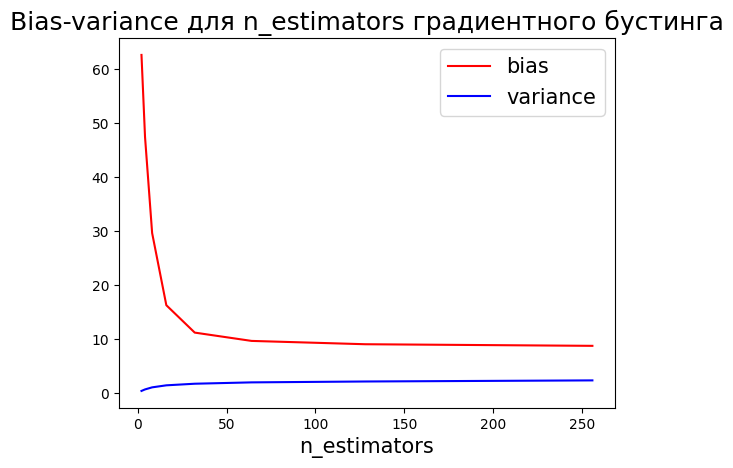

In [427]:
plt.title(f'Bias-variance для n_estimators градиентного бустинга', fontsize=18)
plt.plot(param_list, b_list, color='red', label='bias')

plt.plot(param_list, v_list, color='blue', label='variance')

plt.xlabel('n_estimators', fontsize=15)
plt.legend(fontsize=15)

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Чем глубже дерево, тм оно точнее: это и видно на графике, с ростом глубины сокращается смещение. При этом глубина дерева отрицательно влияет на разброс: деревья становятся чувствительней к данным с ростом глубины.

Смещение не так чувствительно к количеству фичей для сплитов, как разброс. Получается, деревья более устойчивы, если мы ищем оптимальный сплит по всем доступным фичам, а не по ограниченному количеству рандомно определенных: это действительно логично. Смещение также падает, но менее значительно. Точность алгоритма растет с ростом точности определения лучшего сплита) все верно

На третьем граффике хорошо видно, что Bagging действительно не меняет разброс алгоритма (показывали теоретически на занятиях). При этом разброс сокращается с ростом алгоритмов, темпы сокращения убывают. По сути это задача дата саентиста определить оптимальное количество деревьев для бэггинга, с учетом затраченных мощностей и времени на прогонку. Видим, что снижение разброса для 256 и 512 деревьев незначительно. Можно было остановиться на меньших значениях.

Четвертая картинка демонстрирует особенности бустинга как ансамбля моделей. Бустинг, обратно, снижает смещение, оставляя разброс практически без изменений. Здесь также замечаем, что темпы снижения смещения замедляются стремительно и каждый следующий прогон не делает результаты точнее. Достаточно ~ 100 алгоритмов для минимально доступных смещения и разброса. 



__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__ Ходила без шапки!

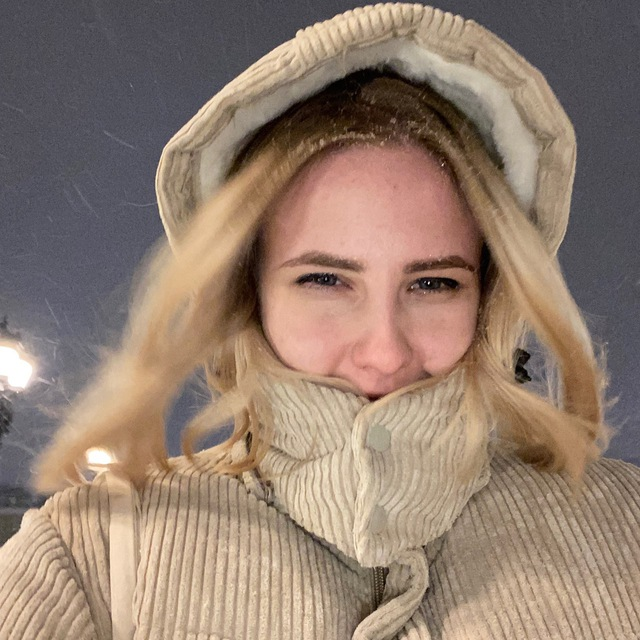